In [239]:
import pandas as pd
from datetime import timedelta
import glob
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import requests
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from xgboost import XGBClassifier

from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix

In [2]:
# Import CSV Containing IPO Information - Ticker, Industry, # of Shares Offered, Offer Price, 1st Day % Return (IPO Scoop)
ipo_csv = pd.read_csv('IPO Project - Sheet2.csv')

In [3]:
# Create "IPO date" DF for later use 
ipo_date = ipo_csv.set_index('Symbol')

In [4]:
# Drop unnecessary columns
ipo_df = ipo_csv.drop(columns=['1st Day Close'])

# Assign stock ticker as index
ipo_df.set_index('Symbol',inplace=True)

# Create date columns for parsing that represent a 90 day period starting 10days before IPO Offer date
ipo_df['Offer Date'] = pd.to_datetime(ipo_df['Offer Date'])
ten_days = pd.to_timedelta(10,'d')
three_months = pd.to_timedelta(100,'d')

ipo_df['T-10D'] = ipo_df['Offer Date']-ten_days
ipo_df['T-90D'] = ipo_df['Offer Date']-three_months
ipo_df['T+100D'] = ipo_df['Offer Date']+three_months

In [5]:
# Convert dates to strings for use in Yahoo Finance API
ipo_df['T-10D'] = ipo_df['T-10D'].astype(str)
ipo_df['T-90D'] = ipo_df['T-90D'].astype(str)
ipo_df['T+100D'] = ipo_df['T+100D'].astype(str)

In [6]:
# Use Yahoo Finance data to measure returns for above-mentioned 100 day period
for ticker in ipo_df.index:
    data = yf.download('SPY',ipo_df.loc[ticker,'T-90D'],ipo_df.loc[ticker,'T-10D'],progress=False)
    spy_return = (data.iloc[-1,-2] - data.iloc[0,-2])/data.iloc[0,-2]
    ipo_df.loc[ticker,'SPY 90D Return'] = spy_return

#Use Yahoo Finance data to measure returns for +100 days
    data2 = yf.download(ticker,ipo_df.loc[ticker,'Offer Date'],ipo_df.loc[ticker,'T+100D'], progress=False)
    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
    ipo_df.loc[ticker,'100 day Return'] = stock_return

In [7]:
# Encode Offer Date to week of year
for ticker in ipo_df.index:
    ipo_df.loc[ticker,'Offer Date'] = ipo_df.loc[ticker,'Offer Date'].isocalendar()[1]

In [8]:
# Create binary encoded column for whether or not stock saw positive gains after 100 days
returns_bin = []
for pct in ipo_df['100 day Return']:
    if pct >= 0:
        returns_bin.append(1)
    else:
        returns_bin.append(0)
        
ipo_df['100D Y/N'] = returns_bin

#Encoding "Industry" Column
le = LabelEncoder()
le.fit(ipo_df["Industry"])
ipo_df["Industry"] = le.transform(ipo_df["Industry"])

# Drop unecessary date columns
ipo_df.drop(columns=['T-10D','T-90D','T+100D'], inplace=True)

In [9]:
# Use glob to create categorized lists of Yahoo Finance CSV's for parsing
bs_list = glob.glob("*_annual_balance-sheet.csv")
cf_list = glob.glob("*_annual_cash-flow.csv")
af_list = glob.glob("*_annual_financials.csv")
list_of_lists = [bs_list,cf_list,af_list]

In [10]:
# Clean and organize CSV
def step_1(frame):
    frame_df = frame.set_index('name')
    
    # Delete TTM column as this data may be more recent than date of IPO
    if 'ttm' in frame_df.columns: 
        frame_df.drop(columns = 'ttm',inplace=True)
    else:
        pass
    
    # Keep only latest annual financial data from year prior to IPO
    if len(frame_df) == 0:
        pass
    else:
        frame_df = frame_df.iloc[:,0]
    
    # Fill NaN's
        frame_df = pd.DataFrame(frame_df.fillna(0))
    
    # Transpose DataFrame
        frame_df = frame_df.T
    
    # Standardize index
        frame_df = frame_df.reset_index()
    
    #Remove '\t...' from column names
        frame_df.columns = frame_df.columns.str.strip()
    
        return frame_df

In [227]:
#Create dataframe for CSV per respective category
def step_2(list):
    df = pd.DataFrame()
    
    # Loop through each list of YF Financials and clean CSV
    for file in list:
        
        # Read in CSV
        path = Path(file)
        csv = pd.read_csv(path, engine='python')
        
        # Clean CSV using step_1 function
        step = step_1(csv)
        
        # Add data from csv to df
        df = pd.concat([df,step], axis = 0)
        
        # Fill NaNs
        df = df.fillna(0)
        
        # Remove "\t" from column names
        df.columns = df.columns.str.strip()
        
        # Reset index
        df.reset_index(drop=True, inplace=True)
        
        # Drop useless column
        #df.drop(columns='index',inplace=True)
    
    # Loop through columns and drop columns that have 0 for more than 20% of the data therein
    for column in df.columns[1:]:
        zeros = (df[column]==0).sum()
        if zeros >= 0.8*len(df.index):
            df.drop(columns = column, inplace = True)
        else:
            pass
    
    return df

In [228]:
# Create dataframe concatenated from respective categorical dataframes
def step_3(list):
    df = pd.DataFrame()
    tickers = []
    
    # Loop through each list of respective YF CSVs
    for l in list_of_lists:
        
        #Clean and concatenate CSV based on category
        frame = step_2(l)
        df = pd.concat([df,frame],axis=1)
    
    # Drop random NaN row?
    print(len(df))
    #df = df.dropna()
    
    #Clean and update index for syntax
    for name in bs_list:
        tickers.append(name[:4])

    df.index = tickers
    
    for x in df.index:
        if x[3] == '_':
             df.rename(index={x:x[:3]},inplace=True)
        elif x[2] == '_':
            df.rename(index={x:x[:2]},inplace=True)
        elif x[1] == '_':
            df.rename(index={x:x[:1]},inplace=True)
        else:
            pass
    
    return df

In [229]:
#Running Functions and Compiling DFs
bz_df = step_3(list_of_lists)
bz_ipo_df = pd.concat([bz_df, ipo_df],axis=1)
bz_ipo_df.drop(columns='Return', inplace=True)
bz_ipo_df = bz_ipo_df.dropna()
bz_ipo_df = bz_ipo_df.drop(columns='index')

309


In [230]:
bz_ipo_df.loc[:,'Industry'] = bz_ipo_df.loc[:,'Industry'].astype(str)
bz_ipo_df.loc[:,'100D Y/N'] = bz_ipo_df.loc[:,'100D Y/N'].astype(str)

In [231]:
for column in bz_ipo_df.columns:
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].astype(str)
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace(',','').astype(float)

C:\Users\tjmcd\AppData\Local\Temp/ipykernel_32396/1029865757.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')


In [232]:
# Drop 100 Day Returns column so that it doesn't wind up in training split
bz_ipo_df.drop(columns='100 day Return', inplace=True)

In [233]:
bz_ipo_df['100D Y/N'].value_counts()

0.0    214
1.0     92
Name: 100D Y/N, dtype: int64

In [241]:
bz_ipo_df.columns

Index(['TotalAssets', 'CurrentAssets',
       'CashCashEquivalentsAndShortTermInvestments', 'CashAndCashEquivalents',
       'Receivables', 'OtherReceivables', 'PrepaidAssets',
       'OtherCurrentAssets', 'TotalNonCurrentAssets',
       'NonCurrentDeferredAssets',
       ...
       'OtherOperatingExpenses', 'ReconciledCostOfRevenue',
       'SellingAndMarketingExpense', 'SpecialIncomeCharges', 'Industry',
       'Offer Date', 'Shares (millions)', 'Offer Price', 'SPY 90D Return',
       '100D Y/N'],
      dtype='object', length=201)

In [17]:
# Split and scale data
X = bz_ipo_df.iloc[:, 0:-1]
y = bz_ipo_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Use RandomOverSampler to balance data
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Use PyTorch's NN Binary Classification Model

In [19]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.1

## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_resampled), 
                       torch.FloatTensor(y_resampled))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [20]:
# Design NN
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 70.
        self.layer_1 = nn.Linear(200, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# Build the NN

model = BinaryClassification()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [22]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [23]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

Epoch 001: | Loss: 0.68761 | Acc: 56.800
Epoch 002: | Loss: 0.59992 | Acc: 66.800
Epoch 003: | Loss: 0.51524 | Acc: 76.200
Epoch 004: | Loss: 0.43274 | Acc: 81.600
Epoch 005: | Loss: 0.39654 | Acc: 84.600
Epoch 006: | Loss: 0.34587 | Acc: 84.600
Epoch 007: | Loss: 0.30272 | Acc: 86.400
Epoch 008: | Loss: 0.31933 | Acc: 85.600
Epoch 009: | Loss: 0.27749 | Acc: 87.800
Epoch 010: | Loss: 0.25015 | Acc: 90.800
Epoch 011: | Loss: 0.22606 | Acc: 90.400
Epoch 012: | Loss: 0.20125 | Acc: 91.200
Epoch 013: | Loss: 0.21856 | Acc: 90.600
Epoch 014: | Loss: 0.18326 | Acc: 93.200
Epoch 015: | Loss: 0.18829 | Acc: 93.000
Epoch 016: | Loss: 0.16363 | Acc: 94.400
Epoch 017: | Loss: 0.18577 | Acc: 91.400
Epoch 018: | Loss: 0.14379 | Acc: 95.200
Epoch 019: | Loss: 0.12416 | Acc: 96.800
Epoch 020: | Loss: 0.14861 | Acc: 93.800
Epoch 021: | Loss: 0.14512 | Acc: 94.200
Epoch 022: | Loss: 0.22055 | Acc: 92.000
Epoch 023: | Loss: 0.14639 | Acc: 94.400
Epoch 024: | Loss: 0.12687 | Acc: 94.400
Epoch 025: | Los

In [25]:
print('PyTorch Model Confusion Matrix')
print(confusion_matrix(y_test, y_pred_list))
print()
print("PyTorch Model Classification Report")
print(classification_report(y_test, y_pred_list))

PyTorch Model Confusion Matrix
[[39 18]
 [ 9 11]]

PyTorch Model Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.68      0.74        57
         1.0       0.38      0.55      0.45        20

    accuracy                           0.65        77
   macro avg       0.60      0.62      0.60        77
weighted avg       0.70      0.65      0.67        77



# Use RandomForest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

#Create an RF Classifier
clf_rf=RandomForestClassifier(n_estimators=1000, random_state=1)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf.fit(X_resampled,y_resampled)

rf_pred=clf_rf.predict(X_test)

RF Confusion Matrix
[[48  9]
 [17  3]]

RF Classification Report
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79        57
         1.0       0.25      0.15      0.19        20

    accuracy                           0.66        77
   macro avg       0.49      0.50      0.49        77
weighted avg       0.61      0.66      0.63        77



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


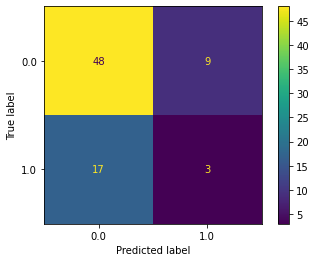

In [27]:
print('RF Confusion Matrix')
print(confusion_matrix(y_test, rf_pred))
print()
print("RF Classification Report")
print(classification_report(y_test, rf_pred)) 
plot_confusion_matrix(clf_rf, X_test, y_test)

In [210]:
feature_imp = pd.Series(clf_rf.feature_importances_,index=bz_ipo_df.columns[0:-1]).sort_values(ascending=False)
feature_imp.to_csv('Feature Importance.csv')
feature_imp

Offer Date                                             0.043421
InvestedCapital                                        0.013331
SPY 90D Return                                         0.013099
TotalLiabilitiesNetMinorityInterest                    0.012707
CashAndCashEquivalents                                 0.011619
TotalRevenue                                           0.011036
ChangeInWorkingCapital                                 0.010986
CashFlowFromContinuingFinancingActivities              0.010420
OperatingRevenue                                       0.009763
RetainedEarnings                                       0.009601
CommonStock                                            0.009311
ChangeInOtherCurrentLiabilities                        0.009020
ChangesInCash                                          0.008938
ProvisionandWriteOffofAssets                           0.008737
PurchaseOfPPE                                          0.008612
TotalAssets                             

# Use ADABoost w SVC

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

model = AdaBoostClassifier(n_estimators = 10000, learning_rate = 1)
svc = SVC(probability = True, kernel = 'rbf')
ada = AdaBoostClassifier(n_estimators = 300, base_estimator = svc, learning_rate = .01)
ada.fit(X_resampled, y_resampled)
yhat = ada.predict(X_test)

In [30]:
print('ADA + SVC Confusion Matrix')
print(confusion_matrix(y_test, yhat))
print()
print("ADA + SVC Classification Report")
print(classification_report(y_test, yhat))
plot_confusion_matrix(ada, X_test, y_test)

# VotingClassifier with LR, RF, SVC

In [31]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=1000, random_state=1)
clf3 = SVC(probability = True, kernel = 'sigmoid', random_state=1)

clf3.fit(X_resampled, y_resampled)
clf3_pred = clf3.predict(X_test)

eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), 
    ('svc', clf3)], voting='hard')
eclf1 = eclf1.fit(X_resampled, y_resampled)
eclf1_pred = eclf1.predict(X_test)

eclf2 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('svc', clf3)],
        voting='soft')
eclf2 = eclf2.fit(X_resampled, y_resampled)
eclf2_pred = eclf2.predict(X_test)

eclf3 = VotingClassifier(estimators=[
       ('lr', clf1), ('rf', clf2), ('svc', clf3)],
       voting='soft', weights=[1,2,2],
       flatten_transform=True)
eclf3 = eclf3.fit(X_resampled, y_resampled)
eclf3_pred = eclf3.predict(X_test)

LogisticRegression
[[34 23]
 [ 7 13]]

LogisticRegression Classification Report
              precision    recall  f1-score   support

         0.0       0.83      0.60      0.69        57
         1.0       0.36      0.65      0.46        20

    accuracy                           0.61        77
   macro avg       0.60      0.62      0.58        77
weighted avg       0.71      0.61      0.63        77



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


RandomForestClassifier
[[48  9]
 [17  3]]

RandomForestClassifier Classification Report
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79        57
         1.0       0.25      0.15      0.19        20

    accuracy                           0.66        77
   macro avg       0.49      0.50      0.49        77
weighted avg       0.61      0.66      0.63        77

SVC
[[27 30]
 [ 7 13]]

SVC Classification Report
              precision    recall  f1-score   support

         0.0       0.79      0.47      0.59        57
         1.0       0.30      0.65      0.41        20

    accuracy                           0.52        77
   macro avg       0.55      0.56      0.50        77
weighted avg       0.67      0.52      0.55        77



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


VotingClassifier
[[38 19]
 [ 9 11]]

VotingClassifier Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.67      0.73        57
         1.0       0.37      0.55      0.44        20

    accuracy                           0.64        77
   macro avg       0.59      0.61      0.59        77
weighted avg       0.69      0.64      0.66        77



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


VotingClassifier
[[40 17]
 [10 10]]

VotingClassifier Classification Report
              precision    recall  f1-score   support

         0.0       0.80      0.70      0.75        57
         1.0       0.37      0.50      0.43        20

    accuracy                           0.65        77
   macro avg       0.59      0.60      0.59        77
weighted avg       0.69      0.65      0.66        77



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


VotingClassifier
[[44 13]
 [11  9]]

VotingClassifier Classification Report
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.79        57
         1.0       0.41      0.45      0.43        20

    accuracy                           0.69        77
   macro avg       0.60      0.61      0.61        77
weighted avg       0.70      0.69      0.69        77



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


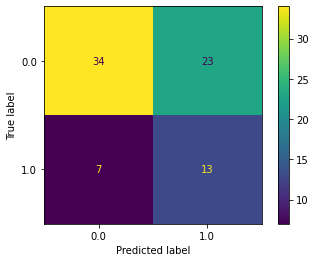

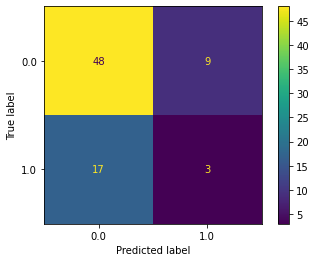

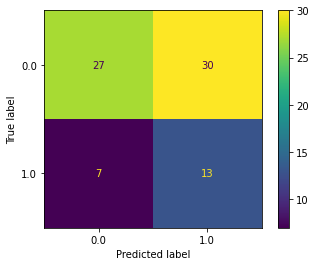

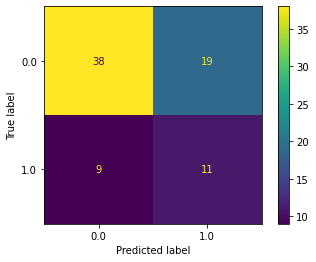

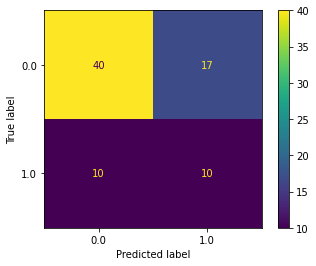

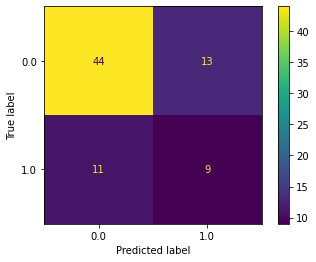

In [32]:
for clf in (clf1, clf2, clf3, eclf1,eclf2,eclf3):
    clf.fit(X_resampled, y_resampled)
    clf_pred = clf.predict(X_test)
    print(clf.__class__.__name__)
    print(confusion_matrix(y_test, clf_pred))
    print()
    print(f"{clf.__class__.__name__} Classification Report")
    print(classification_report(y_test, clf_pred))
    plot_confusion_matrix(clf, X_test, y_test)

# LogisticRegression

In [33]:
LR_classifier = LogisticRegression(solver='lbfgs', random_state=1)
LR_classifier.fit(X_resampled,y_resampled)
LR_predictions = LR_classifier.predict(X_test)

LR Confusion Matrix
[[35 22]
 [ 8 12]]

LR Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.61      0.70        57
         1.0       0.35      0.60      0.44        20

    accuracy                           0.61        77
   macro avg       0.58      0.61      0.57        77
weighted avg       0.69      0.61      0.63        77



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


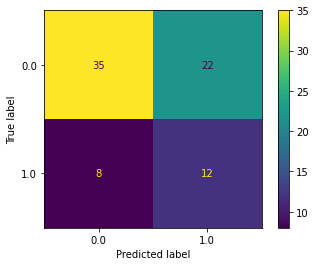

In [34]:
print('LR Confusion Matrix')
print(confusion_matrix(y_test, LR_predictions))
print()
print("LR Classification Report")
print(classification_report(y_test, LR_predictions))
plot_confusion_matrix(LR_classifier, X_test, y_test)

# XGBoost

In [35]:
xgb_model = XGBClassifier()
xgb_model.fit(X_resampled, y_resampled)
xgb_y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in xgb_y_pred]

[22:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGB Confusion Matrix
[[44 13]
 [10 10]]

XGB Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79        57
         1.0       0.43      0.50      0.47        20

    accuracy                           0.70        77
   macro avg       0.62      0.64      0.63        77
weighted avg       0.72      0.70      0.71        77



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


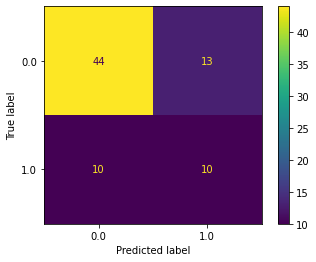

In [36]:
print('XGB Confusion Matrix')
print(confusion_matrix(y_test, predictions))
print()
print("XGB Classification Report")
print(classification_report(y_test, predictions))
plot_confusion_matrix(xgb_model, X_test, y_test)

# Compile Data For Plotting

In [74]:
#Create new dataframe
returns_df = pd.DataFrame()
returns_df = y_test.to_frame()
returns_df['LR Predicted'] = LR_predictions
returns_df['SVC Predicted']= clf3_pred
returns_df['RF Predicted'] = rf_pred
returns_df['VC Predicted'] = eclf3_pred

In [75]:
for ticker in returns_df.index:
    returns_df.loc[ticker,'Returns'] = ipo_df.loc[ticker,'100 day Return']
    returns_df.loc[ticker,'Date'] = ipo_date.loc[ticker,'Offer Date']

In [76]:
for ticker in returns_df.index:
    returns_df.loc[ticker,'Offer Price'] = bz_ipo_df.loc[ticker,'Offer Price']

In [77]:
returns_df['Ticker'] = returns_df.index

In [78]:
returns_df.set_index('Date',inplace=True)

In [79]:
returns_df.index = pd.to_datetime(returns_df.index)

In [80]:
returns_df.sort_index(inplace=True)

In [81]:
for date in returns_df.index:
        returns_df.loc[date,'LR Return'] = (1+returns_df.loc[date,'Returns'])*returns_df.loc[date,'LR Predicted']*returns_df.loc[date,'Offer Price']
        returns_df.loc[date,'SVC Return'] = (1+returns_df.loc[date,'Returns'])*returns_df.loc[date,'SVC Predicted']*returns_df.loc[date,'Offer Price']
        returns_df.loc[date,'RF Return'] = (1+returns_df.loc[date,'Returns'])*returns_df.loc[date,'RF Predicted']*returns_df.loc[date,'Offer Price']
        returns_df.loc[date,'VC Return'] = (1+returns_df.loc[date,'Returns'])*returns_df.loc[date,'VC Predicted']*returns_df.loc[date,'Offer Price']
        returns_df.loc[date,'Not Inv'] = returns_df.loc[date,'LR Predicted']*returns_df.loc[date,'Offer Price']
        returns_df.loc[date,'All Inv'] = (1+returns_df.loc[date,'Returns'])*returns_df.loc[date,'Offer Price']
        returns_df.loc[date,'LR P/L'] = (returns_df.loc[date,'LR Return'] - returns_df.loc[date,'Offer Price']*returns_df.loc[date,'LR Predicted'])
        returns_df.loc[date,'SVC P/L'] = (returns_df.loc[date,'SVC Return'] - returns_df.loc[date,'Offer Price']*returns_df.loc[date,'SVC Predicted'])
        returns_df.loc[date,'RF P/L'] = (returns_df.loc[date,'RF Return'] - returns_df.loc[date,'Offer Price']*returns_df.loc[date,'RF Predicted'])
        returns_df.loc[date,'VC P/L'] = (returns_df.loc[date,'VC Return'] - returns_df.loc[date,'Offer Price']*returns_df.loc[date,'VC Predicted'])
        returns_df.loc[date,'All P/L'] = returns_df.loc[date,'All Inv'] - returns_df.loc[date,'Offer Price']

In [82]:
returns_df['VC Predicted'].value_counts()

0.0    55
1.0    22
Name: VC Predicted, dtype: int64

In [83]:
returns_df['100D LR Return'] = returns_df['Returns']*returns_df['LR Predicted']
returns_df['100D SVC Return'] = returns_df['Returns']*returns_df['SVC Predicted']
returns_df['100D RF Return'] = returns_df['Returns']*returns_df['RF Predicted']
returns_df['100D VC Return'] = returns_df['Returns']*returns_df['VC Predicted']

In [84]:
returns_df['Cum Act Return'] = returns_df['All P/L'].cumsum()

In [85]:
returns_df['Cum LR Return'] = returns_df['LR P/L'].cumsum()
returns_df['Cum SVC Return'] = returns_df['SVC P/L'].cumsum()
returns_df['Cum RF Return'] = returns_df['RF P/L'].cumsum()
returns_df['Cum VC Return'] = returns_df['VC P/L'].cumsum()

In [86]:
returns_df['Sell Date'] = returns_df.index+three_months
returns_df['Buy Date'] = returns_df['Sell Date']-three_months

In [87]:
spy_data = yf.download('SPY',returns_df.index[0],returns_df['Sell Date'][-1])

[*********************100%***********************]  1 of 1 completed


In [88]:
spy_frame = pd.DataFrame(index=pd.date_range(start='2021-02-12', end='2022-03-26'))
spy_frame['Open'] = spy_data['Open']
spy_frame['Close'] = spy_data['Close']
spy_frame.fillna(method='ffill', inplace=True)
spy_frame['Shifted Open'] = spy_frame['Open'].shift(periods=100)
spy_frame.dropna()
spy_frame['SPY $ Return'] = (spy_frame['Close']-spy_frame['Shifted Open'])
spy_frame.dropna(inplace=True)

In [89]:
returns_df['Sell Date'] = returns_df.index+three_months
returns_df['Buy Date'] = returns_df['Sell Date']-three_months

In [90]:
returns_df_sell = returns_df.set_index('Sell Date')

In [91]:
for date in returns_df_sell.index:
    returns_df_sell.loc[date,'SPY $ Return'] = spy_frame.loc[date,'SPY $ Return']

In [93]:
returns_df_sell['Cum SPY Return'] = (returns_df_sell['SPY $ Return']*returns_df_sell['VC Predicted']).cumsum()

In [190]:
returns_df_sell['VC P/L'].dtypes

dtype('float64')

In [196]:
for i in range(len(returns_df_sell.index)):
    if returns_df_sell['VC P/L'][i] > 0:
        returns_df_sell['Green'][i] == returns_df_sell['Cum VC Return'][i]
    elif returns_df_sell['VC P/L'][i] < 0:
        returns_df_sell['Red'][i] == returns_df_sell['Cum VC Return'][i]
    else:
        pass

In [201]:
returns_df_sell.Green = returns_df_sell.Green.replace(0,np.nan)
returns_df_sell.Red = returns_df_sell.Red.replace(0,np.nan)

In [238]:
returns_df_sell

,100D Y/N,LR Predicted,SVC Predicted,RF Predicted,VC Predicted,Returns,Offer Price,Ticker,LR Return,SVC Return,RF Return,VC Return,Not Inv,All Inv,LR P/L,SVC P/L,RF P/L,VC P/L,All P/L,100D LR Return,100D SVC Return,100D RF Return,100D VC Return,Cum Act Return,Cum LR Return,Cum SVC Return,Cum RF Return,Cum VC Return,Buy Date,SPY $ Return,Cum SPY Return,Green,Red
Sell Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-23,0.0,1.0,1.0,0.0,0.0,-0.257008,17.00,NEXI,12.630872,12.630872,0.000000,0.000000,17.0,12.630872,-4.369128,-4.369128,0.000000,0.000000,-4.369128,-0.257008,-0.257008,-0.000000,-0.000000,-4.369128,-4.369128,-4.369128,0.000000,0.000000,2021-02-12,25.089996,0.000000,NaN,NaN
2021-06-26,0.0,0.0,0.0,0.0,0.0,-0.149180,11.00,GANX,0.000000,0.000000,0.000000,0.000000,0.0,9.359017,0.000000,0.000000,0.000000,0.000000,-1.640983,-0.000000,-0.000000,-0.000000,-0.000000,-6.010111,-4.369128,-4.369128,0.000000,0.000000,2021-03-18,32.129974,0.000000,NaN,NaN
2021-07-02,0.0,0.0,1.0,0.0,0.0,-0.204480,25.00,ACVA,0.000000,19.888000,0.000000,0.000000,0.0,19.888000,0.000000,-5.112000,0.000000,0.000000,-5.112000,-0.000000,-0.204480,-0.000000,-0.000000,-11.122111,-4.369128,-9.481127,0.000000,0.000000,2021-03-24,42.720001,0.000000,NaN,NaN
2021-07-03,1.0,1.0,1.0,0.0,1.0,0.948889,20.00,CRCT,38.977780,38.977780,0.000000,38.977780,20.0,38.977780,18.977780,18.977780,0.000000,18.977780,18.977780,0.948889,0.948889,0.000000,0.948889,7.855669,14.608652,9.496653,0.000000,18.977780,2021-03-25,47.739990,47.739990,18.977780,NaN
2021-07-03,1.0,1.0,0.0,0.0,0.0,0.230843,21.00,VZIO,25.847712,0.000000,0.000000,0.000000,21.0,25.847712,4.847712,0.000000,0.000000,0.000000,4.847712,0.230843,0.000000,0.000000,0.000000,12.703381,19.456364,9.496653,0.000000,18.977780,2021-03-25,47.739990,47.739990,NaN,NaN
2021-07-03,1.0,1.0,1.0,0.0,1.0,0.090373,20.00,OLK,21.807453,21.807453,0.000000,21.807453,20.0,21.807453,1.807453,1.807453,0.000000,1.807453,1.807453,0.090373,0.090373,0.000000,0.090373,14.510834,21.263817,11.304106,0.000000,20.785233,2021-03-25,47.739990,95.479980,20.785233,NaN
2021-07-09,0.0,1.0,1.0,1.0,1.0,-0.541390,18.00,ACHL,8.254985,8.254985,8.254985,8.254985,18.0,8.254985,-9.745015,-9.745015,-9.745015,-9.745015,-9.745015,-0.541390,-0.541390,-0.541390,-0.541390,4.765820,11.518803,1.559091,-9.745015,11.040219,2021-03-31,40.179993,135.659973,NaN,11.040219
2021-07-10,0.0,1.0,1.0,1.0,1.0,-0.165517,19.00,ULCC,15.855172,15.855172,15.855172,15.855172,19.0,15.855172,-3.144828,-3.144828,-3.144828,-3.144828,-3.144828,-0.165517,-0.165517,-0.165517,-0.165517,1.620991,8.373974,-1.585737,-12.889843,7.895390,2021-04-01,37.119995,172.779968,NaN,7.895390
2021-07-18,0.0,0.0,1.0,1.0,0.0,-0.554272,17.00,VECT,0.000000,7.577384,7.577384,0.000000,0.0,7.577384,0.000000,-9.422616,-9.422616,0.000000,-9.422616,-0.000000,-0.554272,-0.554272,-0.000000,-7.801625,8.373974,-11.008353,-22.312459,7.895390,2021-04-09,22.949982,172.779968,NaN,NaN


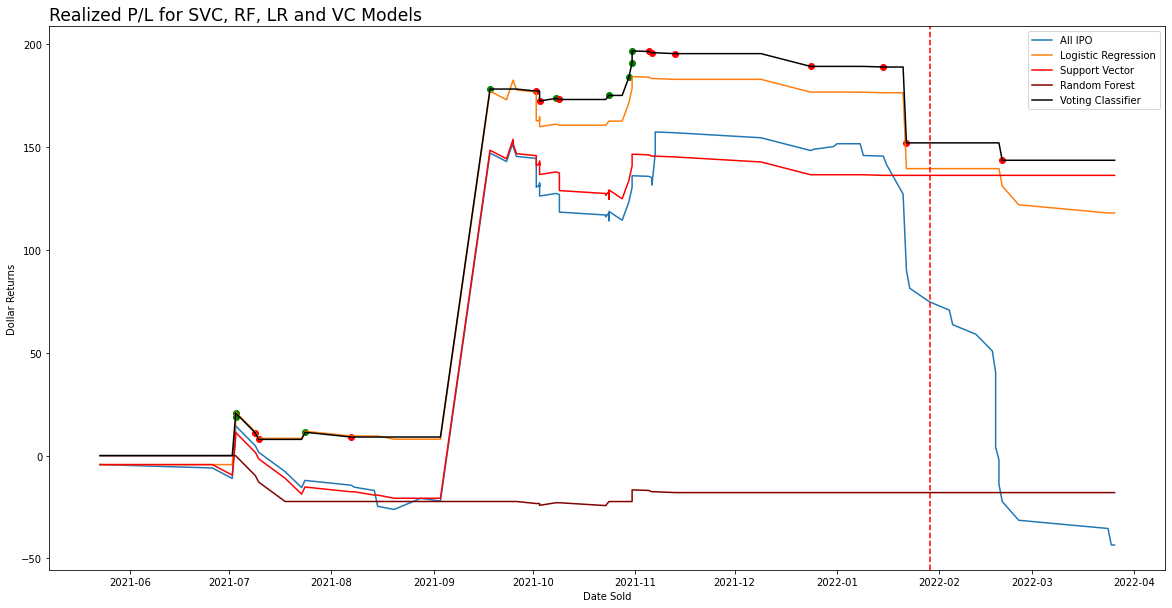

In [205]:
y3_set=returns_df_sell['Cum VC Return']*returns_df_sell['VC Predicted']
y3_set = y3_set.replace(0,np.nan).to_frame()

for date in y3_set.index:
    y3_set.loc[date,'Ticker'] = returns_df_sell.loc[date,'Ticker']
    y3_set.loc[date,'VC Return PCT'] = returns_df_sell.loc[date,'100D VC Return']
y3_set.rename(columns = {0:'$ Returns'}, inplace=True)

x=returns_df_sell.index
y1=returns_df_sell['Cum Act Return']
y2=returns_df_sell['Cum LR Return']
y3=returns_df_sell['Cum SVC Return']
y4=returns_df_sell['Cum RF Return']
y5=returns_df_sell['Cum VC Return']
y6=(y3_set.loc[:,'$ Returns'])
y7=returns_df_sell['Cum SPY Return']
y8 = returns_df_sell.Red
y9 = returns_df_sell.Green

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(x,y1,label='All IPO')
plt.plot(x,y2,label='Logistic Regression')
plt.plot(x,y3,label='Support Vector', color='red')
plt.plot(x,y4,label='Random Forest', color = 'maroon')
plt.plot(x,y5,label='Voting Classifier', color = 'black')
plt.ylabel('Dollar Returns')
plt.xlabel('Date Sold')



plt.scatter(x,y9,color='green')
plt.scatter(x,y8,color='red')
#plt.scatter(x,red,color='red')           
plt.legend()
plt.axvline(pd.to_datetime('2022-01-29'), color ='red', linestyle="--")
plt.title('Realized P/L for SVC, RF, LR and VC Models', loc='left', fontsize='xx-large');

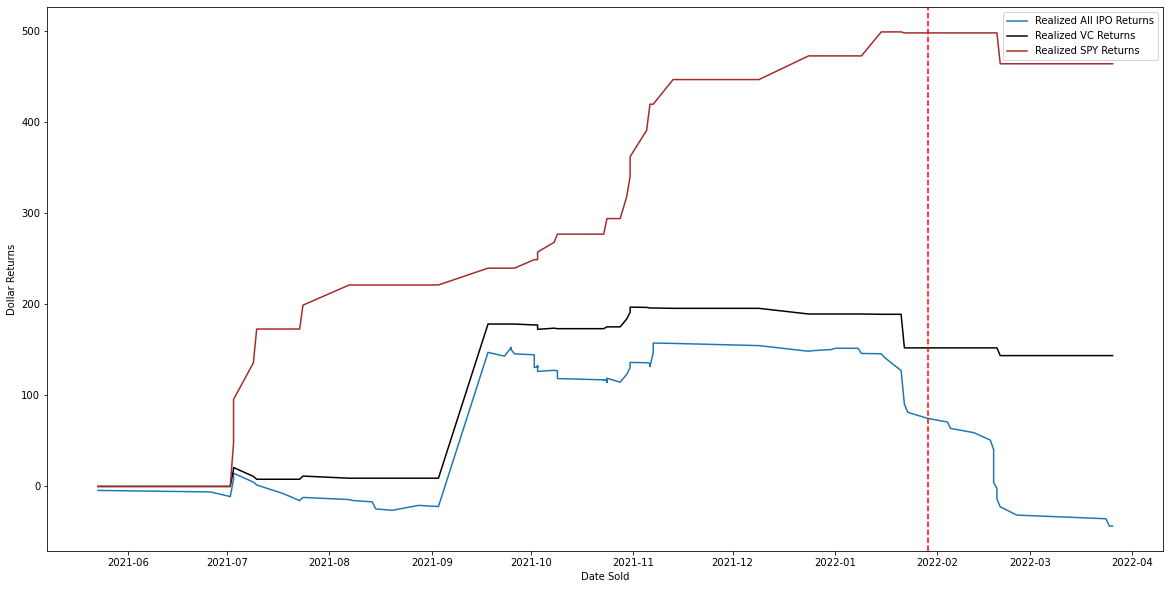

In [237]:
y3_set=returns_df_sell['Cum VC Return']*returns_df_sell['VC Predicted']
y3_set = y3_set.replace(0,np.nan).to_frame()

for date in y3_set.index:
    y3_set.loc[date,'Ticker'] = returns_df_sell.loc[date,'Ticker']
    y3_set.loc[date,'VC Return PCT'] = returns_df_sell.loc[date,'100D VC Return']
y3_set.rename(columns = {0:'$ Returns'}, inplace=True)

x=returns_df_sell.index
y1=returns_df_sell['Cum Act Return']
y2=returns_df_sell['Cum VC Return']
y3=(y3_set.loc[:,'$ Returns'])
y4=returns_df_sell['Cum SPY Return']

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(x,y1,label='Realized All IPO Returns')
plt.plot(x,y2,label='Realized VC Returns',color='black')
plt.plot(x,y4,label='Realized SPY Returns',color='brown')
plt.ylabel('Dollar Returns')
plt.xlabel('Date Sold')
#plt.scatter(x,y4,color='green')
plt.legend()
plt.title('')
plt.axvline(pd.to_datetime('2022-01-29'), color ='red', linestyle="--");